In [9]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Downloaded from https://data.mendeley.com/datasets/tywbtsjrjv/1/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc
original_path = "D:\Kaio_Poc_Telhas\Plant_leave_diseases_dataset_without_augmentation"
train_val_folder = "D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format"

# Esse label não faz sentido dentro do nosso propósito
# Logo imagens dessa classe serão IGNORADAS
label_to_be_removed = "Background_without_leaves"

images_path = original_path

labels = os.listdir(images_path)
images_metadata = []

for label in labels:
    if label == label_to_be_removed:
        continue

    label_path = os.path.join(images_path, label)
    label_images = [label_file for label_file in os.listdir(label_path) if label_file.lower().endswith(".jpg")]
    
    images_metadata.append({
        "label": label,
        "path": label_path,
        "train": train_val_folder + "\\train\\" + label,
        "val": train_val_folder + "\\val\\" + label,
        "images": label_images
    })
    #images_dict[label] = label_images
    
for image_metadata in images_metadata:
    print("Label: {label}, Path: {path}, Train path: {train}, Val path: {val}, Images: {images}\n\n"
          .format(label = image_metadata["label"], path = image_metadata["path"], train = image_metadata["train"],
                 val = image_metadata["val"], images = len(image_metadata["images"])))

Label: Apple___Apple_scab, Path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_dataset_without_augmentation\Apple___Apple_scab, Train path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\train\Apple___Apple_scab, Val path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Apple___Apple_scab, Images: 630


Label: Apple___Black_rot, Path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_dataset_without_augmentation\Apple___Black_rot, Train path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\train\Apple___Black_rot, Val path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Apple___Black_rot, Images: 621


Label: Apple___Cedar_apple_rust, Path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_dataset_without_augmentation\Apple___Cedar_apple_rust, Train path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\train\Apple___Cedar_apple_rust, Val path: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Apple___Cedar_apple_rust, Images: 275


Label: Apple__

In [10]:
len(images_metadata)

38

In [2]:
# Criando pastas no formato do tutorial

if not os.path.exists(train_val_folder):
    os.makedirs(train_val_folder)

for folder in ["train", "val"]:
    folder_fullpath = os.path.join(train_val_folder, folder)
    
    if not os.path.exists(folder_fullpath):
        os.makedirs(folder_fullpath)
        
    for data in images_metadata:
        label_folder_path = os.path.join(folder_fullpath, data["label"])
        
        if not os.path.exists(label_folder_path):
            os.makedirs(label_folder_path)
            
        #data[folder] = label_folder_path

In [3]:
# Adicionando imagens em cada pasta
# SE EXECUTAR MAIS DE UMA VEZ, VAI ADICIONAR NOVAMENTE AS IMAGENS!

from sklearn.utils import shuffle
import shutil

for data in images_metadata:
    print(data["label"])
    
    images_len = len(data["images"])
    train_len = round(images_len * 0.8)
    
    shuffled_images = shuffle(data["images"], random_state=0)
    
    train_images = shuffled_images[:train_len]
    val_images = shuffled_images[train_len:]
    
    assert len(train_images) + len(val_images) == images_len, "Problema no cálculo da quantidade de imagens de treino e teste!"
    
    for image_type in ["train", "val"]:
        
        if image_type == "train":
            path_to_save = data["train"]
            images_to_save = train_images
        else:
            path_to_save = data["val"]
            images_to_save = val_images
            
        image_folder_source = data["path"]
        
        for image_to_save in images_to_save:
            source_fullpath = os.path.join(image_folder_source, image_to_save)
            destiny_fullpath = os.path.join(path_to_save, image_to_save)
            
            shutil.copyfile(source_fullpath, destiny_fullpath)
    
    
#images_metadata

Apple___Apple_scab
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___healthy
Blueberry___healthy
Cherry___healthy
Cherry___Powdery_mildew
Corn___Cercospora_leaf_spot Gray_leaf_spot
Corn___Common_rust
Corn___healthy
Corn___Northern_Leaf_Blight
Grape___Black_rot
Grape___Esca_(Black_Measles)
Grape___healthy
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Orange___Haunglongbing_(Citrus_greening)
Peach___Bacterial_spot
Peach___healthy
Pepper,_bell___Bacterial_spot
Pepper,_bell___healthy
Potato___Early_blight
Potato___healthy
Potato___Late_blight
Raspberry___healthy
Soybean___healthy
Squash___Powdery_mildew
Strawberry___healthy
Strawberry___Leaf_scorch
Tomato___Bacterial_spot
Tomato___Early_blight
Tomato___healthy
Tomato___Late_blight
Tomato___Leaf_Mold
Tomato___Septoria_leaf_spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [3]:
# Checando se não há nenhuma imagem repetida

for data in images_metadata:
    for image in os.listdir(data["train"]):
        assert not image in os.listdir(data["val"]), f"Imagem repetida encontrada! {image}"

In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = train_val_folder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f'Dataset train len: {len(image_datasets["train"])}')
print(f'Dataset val len: {len(image_datasets["val"])}')

torch_version = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f'Torch version: {torch_version}')
device = torch.device(torch_version)

Dataset train len: 43446
Dataset val len: 10857
Torch version: cuda:0


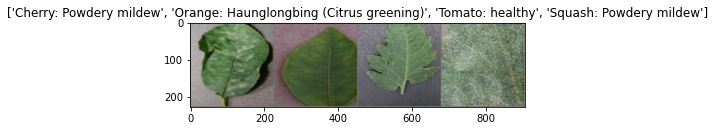

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x].replace("___", ": ").replace("_", " ") for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------
train Loss: 0.6025 Acc: 0.8498
val Loss: 0.1059 Acc: 0.9709

Epoch 1/3
----------
train Loss: 0.1742 Acc: 0.9505
val Loss: 0.0604 Acc: 0.9843

Epoch 2/3
----------
train Loss: 0.1296 Acc: 0.9622
val Loss: 0.0467 Acc: 0.9877

Epoch 3/3
----------
train Loss: 0.1075 Acc: 0.9683
val Loss: 0.0503 Acc: 0.9851

Training complete in 22m 20s
Best val Acc: 0.987658


tensor([10.1162, 10.7615,  7.9749, 14.6359, 11.6330, 12.4467,  8.5666, 11.6640,
        15.0348, 12.3436, 10.5997, 12.4803, 10.9134, 14.2381, 11.8768, 10.0239,
        13.2907, 10.2831, 13.1525, 11.1962, 14.4154, 11.9507,  6.5134, 15.0563,
         9.7720, 13.1100, 16.6364,  9.7897, 11.3124, 11.0904, 12.7797, 14.2823],
       device='cuda:0')


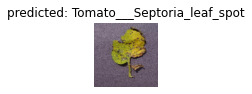

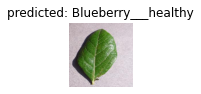

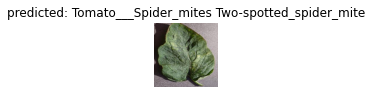

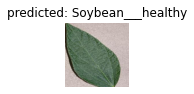

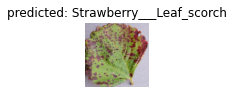

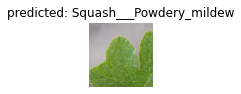

In [19]:
visualize_model(model_ft)

In [10]:
# ConvNet as fixed feature extractor

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 1.3736 Acc: 0.6846
val Loss: 0.5985 Acc: 0.8644

Epoch 1/3
----------
train Loss: 0.7161 Acc: 0.8247
val Loss: 0.4116 Acc: 0.9047

Epoch 2/3
----------
train Loss: 0.5852 Acc: 0.8507
val Loss: 0.3683 Acc: 0.9084

Epoch 3/3
----------
train Loss: 0.5206 Acc: 0.8616
val Loss: 0.3110 Acc: 0.9205

Training complete in 7m 40s
Best val Acc: 0.920512


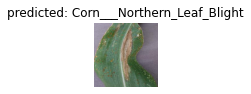

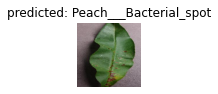

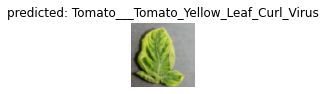

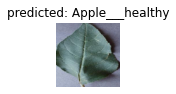

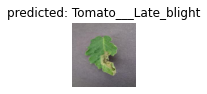

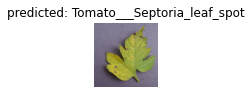

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [9]:
folder_path = "D:\Kaio_Poc_Telhas\Plant_leave_diseases_models"

In [36]:
#Salvando os modelos

torch.save(model_ft.state_dict(), os.path.join(folder_path, "model_ft.pt"))
torch.save(model_conv.state_dict(), os.path.join(folder_path, "model_conv.pt"))

In [10]:
#Carregando os modelos
# https://learn-pytorch.oneoffcoder.com/model-persistence.html

model_ft_load = None
model_conv_load = None

for model_name in ["model_ft", "model_conv"]:

    model_load = models.resnet18(pretrained=True)
    model_load.fc = nn.Linear(model_load.fc.in_features, len(class_names))    
    model_load = model_load.to(device)
    
    model_path = os.path.join(folder_path, f"{model_name}.pt")
    model_load.load_state_dict(torch.load(model_path))
    model_load.eval()
    
    if model_name == "model_ft":
        model_ft_load = model_load
    else:
        model_conv_load = model_load

In [11]:
# Separando imagens para teste

val_images = []

for metadata in images_metadata:
    val_items = os.listdir(metadata["val"])
    val_item = val_items[len(val_items)//2]
    val_item_fullpath = os.path.join(metadata["val"], val_item)
    
    val_images.append({"path": val_item_fullpath, "label": metadata["label"]})
    
    #Image.open(val_item_fullpath)
    
val_images

[{'path': 'D:\\Kaio_Poc_Telhas\\Plant_leave_diseases_train_val_format\\val\\Apple___Apple_scab\\image (359).JPG',
  'label': 'Apple___Apple_scab'},
 {'path': 'D:\\Kaio_Poc_Telhas\\Plant_leave_diseases_train_val_format\\val\\Apple___Black_rot\\image (359).JPG',
  'label': 'Apple___Black_rot'},
 {'path': 'D:\\Kaio_Poc_Telhas\\Plant_leave_diseases_train_val_format\\val\\Apple___Cedar_apple_rust\\image (248).JPG',
  'label': 'Apple___Cedar_apple_rust'},
 {'path': 'D:\\Kaio_Poc_Telhas\\Plant_leave_diseases_train_val_format\\val\\Apple___healthy\\image (240).JPG',
  'label': 'Apple___healthy'},
 {'path': 'D:\\Kaio_Poc_Telhas\\Plant_leave_diseases_train_val_format\\val\\Blueberry___healthy\\image (333).JPG',
  'label': 'Blueberry___healthy'},
 {'path': 'D:\\Kaio_Poc_Telhas\\Plant_leave_diseases_train_val_format\\val\\Cherry___healthy\\image (449).JPG',
  'label': 'Cherry___healthy'},
 {'path': 'D:\\Kaio_Poc_Telhas\\Plant_leave_diseases_train_val_format\\val\\Cherry___Powdery_mildew\\image (54

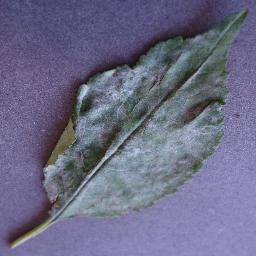

Previsão: Apple___Apple_scab
Real: Cherry___Powdery_mildew
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Cherry___Powdery_mildew\image (540).JPG


Acurácia final: 0.9736842105263158




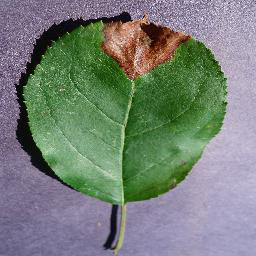

Previsão: Apple___healthy
Real: Apple___Black_rot
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Apple___Black_rot\image (359).JPG




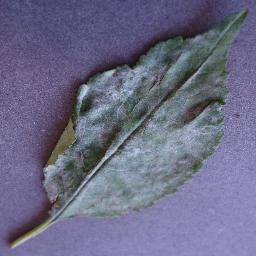

Previsão: Tomato___Early_blight
Real: Cherry___Powdery_mildew
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Cherry___Powdery_mildew\image (540).JPG




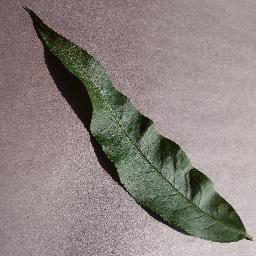

Previsão: Apple___healthy
Real: Peach___healthy
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Peach___healthy\image (273).JPG




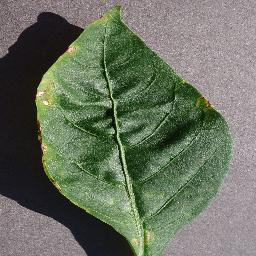

Previsão: Soybean___healthy
Real: Pepper,_bell___Bacterial_spot
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Pepper,_bell___Bacterial_spot\image (537).JPG




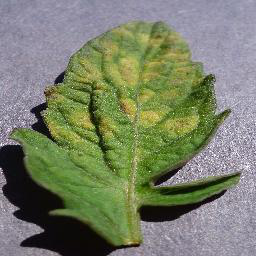

Previsão: Tomato___Septoria_leaf_spot
Real: Tomato___Leaf_Mold
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Tomato___Leaf_Mold\image (504).JPG




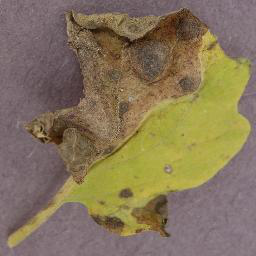

Previsão: Tomato___Late_blight
Real: Tomato___Septoria_leaf_spot
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Tomato___Septoria_leaf_spot\image (19).JPG




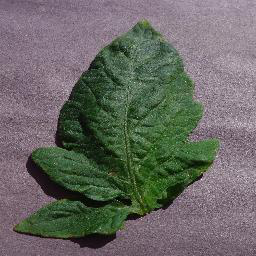

Previsão: Tomato___Spider_mites Two-spotted_spider_mite
Real: Tomato___Target_Spot
Caminho: D:\Kaio_Poc_Telhas\Plant_leave_diseases_train_val_format\val\Tomato___Target_Spot\image (397).JPG


Acurácia final: 0.8157894736842105




In [12]:
# Fazendo a predição das imagens
#https://github.com/qubvel/segmentation_models.pytorch/issues/371
#https://stackoverflow.com/questions/60841650/how-to-test-one-single-image-in-pytorch

from PIL import Image
from IPython.display import display

tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for loaded_model in [model_ft_load, model_conv_load]:
    
    acertos = 0

    for image_data in val_images:
        img = Image.open(image_data["path"])
        #display(IPython.display.Image(filename=image_data["path"]))

        img_tensor = tfms(img).to('cuda').unsqueeze(0)

        output = loaded_model(img_tensor)
        _, preds = torch.max(output, 1)

        label_previsao = class_names[preds[0]]
        label_real = image_data['label']

        if label_previsao == label_real:
            acertos += 1
        else:
            display(img)
            print(f"Previsão: {label_previsao}")
            print(f"Real: {label_real}")
            print(f"Caminho: {image_data['path']}")
            print("\n")

    print(f"Acurácia final: {acertos/len(val_images)}\n\n")

In [13]:
5//2

2

In [20]:
# Construção da matriz de confusão
#https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(loaded_model, title):
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in dataloaders["val"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = loaded_model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

    # constant for classes
    classes = class_names

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * len(class_names), index = [i for i in classes],
                         columns = [i for i in classes])
    print(title)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    #plt.savefig('output.png')

model_ft_load


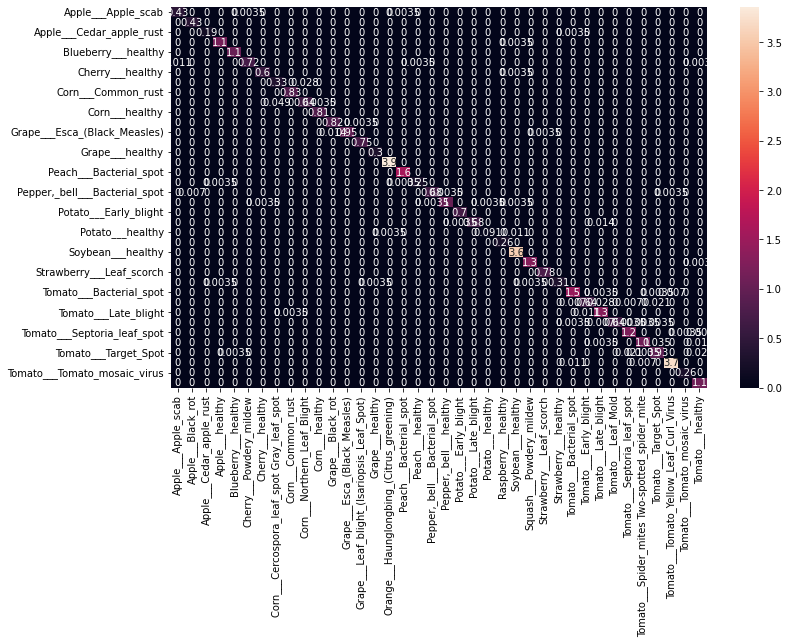

In [25]:
plot_confusion_matrix(model_ft_load, "model_ft_load")

model_conv_load


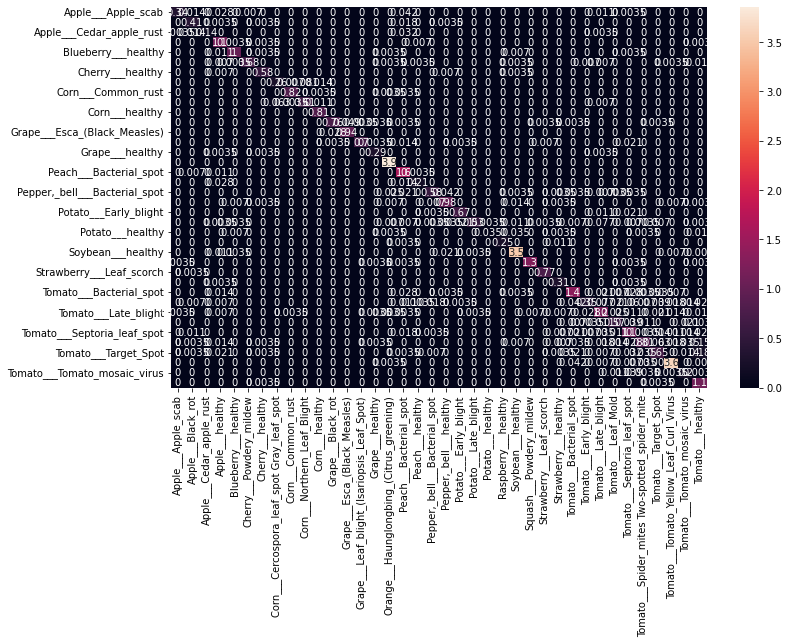

In [23]:
plot_confusion_matrix(model_conv_load, "model_conv_load")